In [26]:
from sympy.interactive import printing
from sympy import Eq, solve, symbols, solve_linear, var

# the principle, solve a closed loop, G forward, H back
u, e, y, H, G = symbols("u e y H G")
eq1 = Eq(e, u - y*H)
eq2 = Eq(y, G*e)
display(eq1)
display(eq2)

display(solve((eq1, eq2), [y, e]))

Eq(e, -H*y + u)

Eq(y, G*e)

{y: G*u/(G*H + 1), e: u/(G*H + 1)}

In [56]:
# Sander's problem, open loop

# tf's nms
Hact, Hgto, Hms, Hi, Harm, Hskin = symbols("H_act H_gto H_ms H_i H_arm H_skin")

# symbols nms
usup, ugto, ums, mrefl, mmus, mi, mres, xarm, xm, mgrip = symbols(
    "u_sup, u_gto, u_ms, u_refl, m_mus, m_i, m_res, x_arm, x_m, m_grip")

# pilot equalization, simple
Hp, e = symbols("H_p e")

# active stick system elements
Kfwd, Hc, Hfb = symbols("K_fwd H_c H_fb")

# active stick system symbols
fd, u, phi = symbols("f_d u \phi")

# equations
eqns = {}

# pilot tf 
eqns["pilot equalisation"] = Eq(usup, Hp*e)

# activation
eqns["activation dynamic"] = Eq(mrefl, (usup - ugto - ums)*Hact)

# ms signal
eqns["ms signal"] = Eq(ums, Hms*xarm)

# muscle force 
eqns["muscle force"] = Eq(mmus, mi+mrefl)

# gto activation output
eqns["gto signal"] = Eq(ugto, Hgto * mmus)

# intrinsic muscle force
eqns["intrinsic muscle force"] = Eq(mi, Hi*xarm)

# resultant force on the limb
eqns["resultant limb force"] = Eq(mres, mmus - mgrip)
     
# arm position
eqns["limb dynamics"] = Eq(xarm, Harm*mres)
     
# grip moment
eqns["grip dynamics"] = Eq(mgrip, Hskin*(xarm - xm))

# system dynamics
eqns["system dynamics"] = Eq(phi, Hc*(fd + Kfwd*mgrip))
     
# manipulator movement
eqns["manipulator movement"] = Eq(xm, Hfb*(phi))
     
# printem all
     
for desc, eq in eqns.items():
     print(desc)
     display(eq)
 

pilot equalisation


Eq(u_sup, H_p*e)

activation dynamic


Eq(u_refl, H_act*(-u_gto - u_ms + u_sup))

ms signal


Eq(u_ms, H_ms*x_arm)

muscle force


Eq(m_mus, m_i + u_refl)

gto signal


Eq(u_gto, H_gto*m_mus)

intrinsic muscle force


Eq(m_i, H_i*x_arm)

resultant limb force


Eq(m_res, -m_grip + m_mus)

limb dynamics


Eq(x_arm, H_arm*m_res)

grip dynamics


Eq(m_grip, H_skin*(x_arm - x_m))

system dynamics


Eq(\phi, H_c*(K_fwd*m_grip + f_d))

manipulator movement


Eq(x_m, H_fb*\phi)

In [61]:
result = solve(eqns.values(), [phi, xm, mgrip, mmus, usup, ugto, mrefl, ums, mres, mi, xarm])

print('response to e input, open loop')

display(result[phi].subs(fd, 0))

print('response to disturbance input, open loop')

display(result[phi].subs(e, 0))


response to e input, open loop


H_act*H_arm*H_c*H_p*H_skin*K_fwd*e/(H_act*H_arm*H_c*H_fb*H_ms*H_skin*K_fwd + H_act*H_arm*H_gto*H_skin + H_act*H_arm*H_ms + H_act*H_c*H_fb*H_gto*H_skin*K_fwd + H_act*H_gto - H_arm*H_c*H_fb*H_i*H_skin*K_fwd - H_arm*H_i + H_arm*H_skin + H_c*H_fb*H_skin*K_fwd + 1)

response to disturbance input, open loop


(H_act*H_arm*H_c*H_gto*H_skin*f_d + H_act*H_arm*H_c*H_ms*f_d + H_act*H_c*H_gto*f_d - H_arm*H_c*H_i*f_d + H_arm*H_c*H_skin*f_d + H_c*f_d)/(H_act*H_arm*H_c*H_fb*H_ms*H_skin*K_fwd + H_act*H_arm*H_gto*H_skin + H_act*H_arm*H_ms + H_act*H_c*H_fb*H_gto*H_skin*K_fwd + H_act*H_gto - H_arm*H_c*H_fb*H_i*H_skin*K_fwd - H_arm*H_i + H_arm*H_skin + H_c*H_fb*H_skin*K_fwd + 1)

In [66]:
# make it a closed-loop system
ut = symbols("u_t")
eqns["display feedback"] = Eq(e, ut - phi)

result2 = solve(eqns.values(), [phi, xm, mgrip, mmus, usup, ugto, mrefl, ums, mres, mi, xarm, e])

print('response to target input, closed loop')

display(result2[phi].subs(fd, 0))
print(result2[phi].subs(fd, 0))

response to target input, closed loop


H_act*H_arm*H_c*H_p*H_skin*K_fwd*u_t/(H_act*H_arm*H_c*H_fb*H_ms*H_skin*K_fwd + H_act*H_arm*H_c*H_p*H_skin*K_fwd + H_act*H_arm*H_gto*H_skin + H_act*H_arm*H_ms + H_act*H_c*H_fb*H_gto*H_skin*K_fwd + H_act*H_gto - H_arm*H_c*H_fb*H_i*H_skin*K_fwd - H_arm*H_i + H_arm*H_skin + H_c*H_fb*H_skin*K_fwd + 1)

H_act*H_arm*H_c*H_p*H_skin*K_fwd*u_t/(H_act*H_arm*H_c*H_fb*H_ms*H_skin*K_fwd + H_act*H_arm*H_c*H_p*H_skin*K_fwd + H_act*H_arm*H_gto*H_skin + H_act*H_arm*H_ms + H_act*H_c*H_fb*H_gto*H_skin*K_fwd + H_act*H_gto - H_arm*H_c*H_fb*H_i*H_skin*K_fwd - H_arm*H_i + H_arm*H_skin + H_c*H_fb*H_skin*K_fwd + 1)


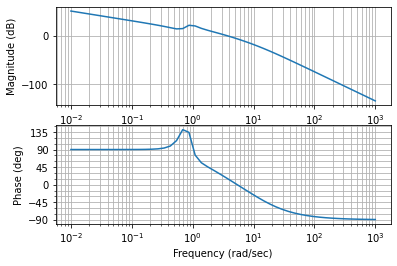

In [81]:
import control.matlab as ml
from control import TransferFunction

# use the control package to get in the tf's
s = TransferFunction.s

K_p = 9
K_v = 2
H_ms = (K_p + K_v*s)*ml.tf(*ml.pade(0.025, 2))

K_f = -1.5
H_gto = K_f*(ml.tf(*ml.pade(0.025, 1)))

I_arm = 0.01
H_arm = 1/(I_arm * s**2)

B_i = 0.08
K_i = 4
H_i = K_i + B_i*s

w_act = 14
b_act = 0.7
H_act = 1/(s**2/w_act**2 + 2*b_act/w_act*s + 1)

K_skin = 165
B_skin = 2
H_skin = K_skin + B_skin*s

# only a gain?
H_p = ml.tf(*ml.pade(0.025, 2))

K_fwd = 2.5
K_phidot = -0.2857
H_fb = K_phidot*s

K_c = -3.5
H_c = K_c*(2.259*s**2 + 0.821*s + 1)/((0.083*s+1)*s*(0.4*s+1)*(1.1647*s**2+0.336*s+1))
res = ml.bode(H_c)




H_act*H_arm*H_c*H_p*H_skin*K_fwd/(H_act*H_arm*H_c*H_fb*H_ms*H_skin*K_fwd + H_act*H_arm*H_gto*H_skin + H_act*H_arm*H_ms + H_act*H_c*H_fb*H_gto*H_skin*K_fwd + H_act*H_gto - H_arm*H_c*H_fb*H_i*H_skin*K_fwd - H_arm*H_i + H_arm*H_skin + H_c*H_fb*H_skin*K_fwd + 1) 

H_act*H_arm*H_c*H_p*H_skin*K_fwd/(H_act*H_arm*H_c*H_fb*H_ms*H_skin*K_fwd + H_act*H_arm*H_c*H_p*H_skin*K_fwd + H_act*H_arm*H_gto*H_skin + H_act*H_arm*H_ms + H_act*H_c*H_fb*H_gto*H_skin*K_fwd + H_act*H_gto - H_arm*H_c*H_fb*H_i*H_skin*K_fwd - H_arm*H_i + H_arm*H_skin + H_c*H_fb*H_skin*K_fwd + 1)


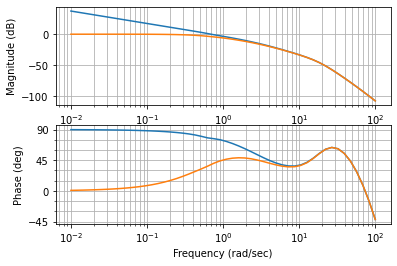

In [101]:
import numpy as np

# this results in an expression for the open loop
expr = str(result[phi].subs({fd: 0, e:1}))
print(expr, '\n')

# run it through eval, so it combines with the tf's defined above
Hopen = eval(expr)
res = ml.bode(Hopen, np.logspace(-2, 2))

expr = str(result2[phi].subs({fd: 0, ut: 1}))
print(expr)
Hclosed = eval(expr)
res = ml.bode(Hclosed, np.logspace(-2, 2))

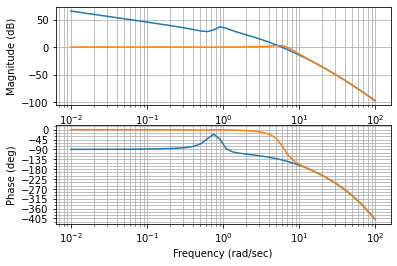

In [99]:
# and now with Hfb = 0
# help(result[phi].subs)
Hopen2 = eval(str(result[phi].subs({fd:0, e:1, Hfb:0})))
res = ml.bode(Hopen2, np.logspace(-2, 2))

Hclosed2 = eval(str(result2[phi].subs({fd:0, ut:1, Hfb:0})))
res = ml.bode(Hclosed2, np.logspace(-2, 2))
              

## conclusions

With the active stick feedback Hfb reduced to 0, the plant dynamics are visible again in the open loop. Because the stick does not move, the effective gain into the system becomes higher. Closed-loop behaviour is good. 

The previous case, with non-zero Hfb, had a lower cross-over because the stick yields. To compensate and get the same effect, pilot gain can be increased. The haptic feedback (present in open-loop already) effectively removes the system dynamics around 1 rad/s